In [1]:
import os 
os.chdir("..")
os.chdir("..")
from src.cpwc.multires.class_multiressolver import *
import matplotlib.pyplot as plt
import torch
from src.cpwc.tools.ptychography import Ptychography as Ptychography
from src.cpwc.tools.utils import *
torch.cuda.empty_cache()
from src.utils.cuda_pyth import empty_cuda, print_cuda_tensors
from src.utils.get_image import get_image
from src.utils.noise import add_gaussian_noise, add_poisson_noise
from src.utils.metrics import get_ring_average
from src.utils.manage_data import save_data,unwrap_2d,extract_data
# Set seeds 
torch.manual_seed(0)
np.random.seed(0)

device = "cuda" if torch.cuda.is_available() else "cpu"
max_scale = 9
image,image_tensor_ = get_image("samples/potential.npy", max_scale,device)
max_probe_size = 128
cycle = [0, -1, -1, -1,  1, 1, 1]
tol = [1e-10] * 9
tol_in = [1e-15] * 9


/home/efe/Desktop/Multiresolution-Framework-for-Fourier-Ptychography/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# % 75 Overlap w/ MRGD
LR = 1e-2
max_shift = 64
I_in = 25*np.array([1, 15, 10, 5, 10, 30, 100])
I_out = 10*np.array([0, 0, 0, 30, 10,10,300])
lmbda = 1e-9
noise = 1e5
linOperator = Ptychography(max_scale = max_scale,max_probe_size = max_probe_size ,max_shift = max_shift,device=device)
multires = MultiRes(max_scale, device)
image_tensor__ = linOperator.apply(image_tensor_)
image_tensor__ = add_poisson_noise(image_tensor__, noise, 'cuda')
loss = Loss(linOperator,image_tensor__,lmbda= lmbda)
model = MultiResSolver(multires, 
                        loss, 
                        LR = LR,
                        I_in = I_in,
                        I_out = I_out,
                        tol = tol,
                        tol_in = tol_in,
                        cycle = cycle,
                        l1_type = "l1_row",
                        gt = image_tensor_)
model.solve_multigrid()
model.print_time()

if max_shift == 32:
    overlap = 75
elif max_shift == 64:
    overlap = 50
else:
    overlap = 25


----------- s = 9 -----------
----------- s = 8 -----------
----------- s = 7 -----------
----------- s = 6 -----------
2
Iter 1, [loss,mse,reg,csim] : [129138.0816046, 129138.0816043, 3e-07, 0.0026169, ] 
2
Iter 2, [loss,mse,reg,csim] : [65642.959016, 65642.9590153, 7e-07, 0.0453203, ] 
2
Iter 3, [loss,mse,reg,csim] : [43738.8742708, 43738.8742701, 7e-07, 0.090257, ] 
2
Iter 4, [loss,mse,reg,csim] : [35111.8710713, 35111.8710707, 6e-07, 0.1294561, ] 
2
Iter 5, [loss,mse,reg,csim] : [30605.8073673, 30605.8073668, 5e-07, 0.1706348, ] 
2
Iter 6, [loss,mse,reg,csim] : [26749.0613, 26749.0612995, 5e-07, 0.2205326, ] 
2
Iter 7, [loss,mse,reg,csim] : [22240.6796308, 22240.6796304, 4e-07, 0.2796021, ] 
2
Iter 8, [loss,mse,reg,csim] : [18748.8479175, 18748.8479171, 4e-07, 0.3287495, ] 
2
Iter 9, [loss,mse,reg,csim] : [16924.5374021, 16924.5374017, 4e-07, 0.3607894, ] 
2
Iter 10, [loss,mse,reg,csim] : [16139.081297, 16139.0812966, 4e-07, 0.378641, ] 
2
Iter 11, [loss,mse,reg,csim] : [15817.6316

In [3]:
path = save_data(model = model,
          image_path= "samples/potential.npy",
          metrics = ['csim','loss','frc',"image"],
          device = "cuda",
          max_scale = 9,
          overlap = overlap,
          spline_type="cpwc",
          lambda_ = lmbda,
          noise_type="poisson",
          noise = noise,
          loop = "mrgd")

In [4]:
image = np.load(path + "_image.npy")

(-0.5, 511.5, 511.5, -0.5)

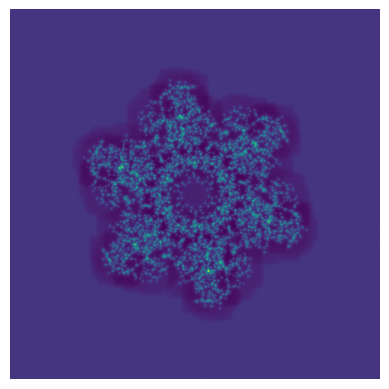

In [5]:
plt.imshow(image)
plt.axis("off")

In [6]:

frc = np.load(path + "_frc.npy")

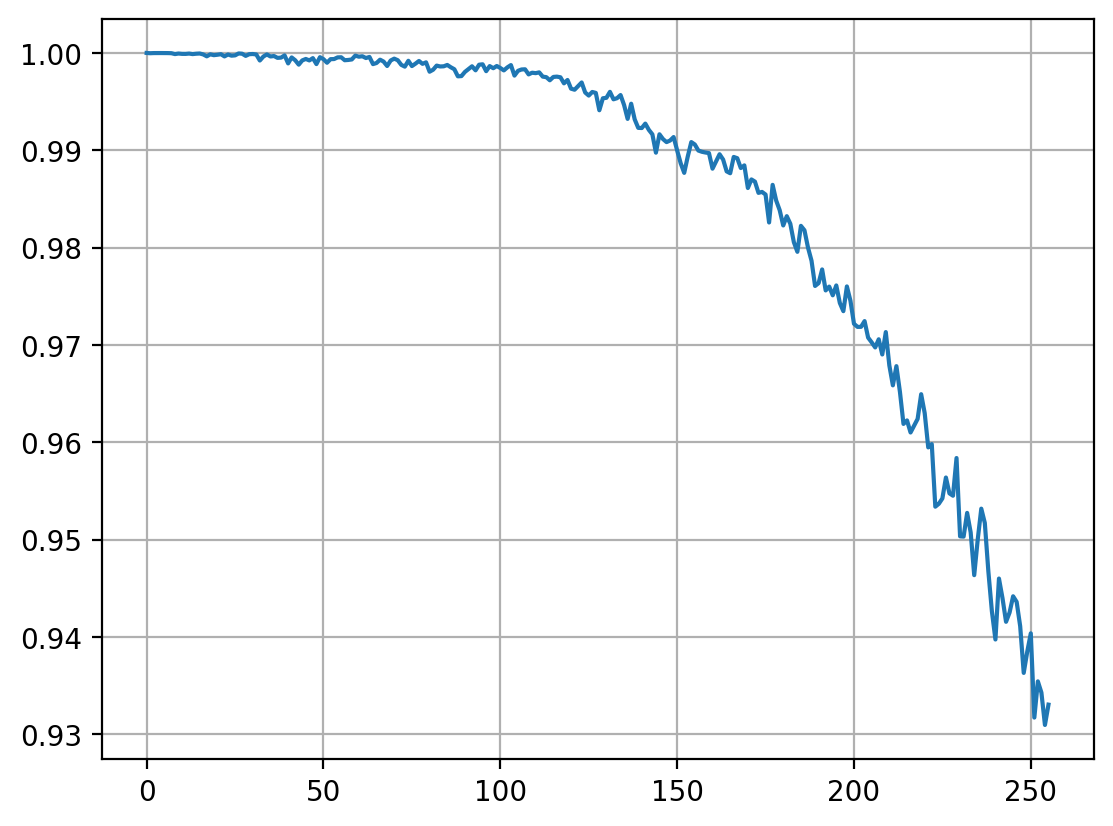

In [7]:
plt.figure(dpi = 200)
plt.plot(frc)
plt.grid()

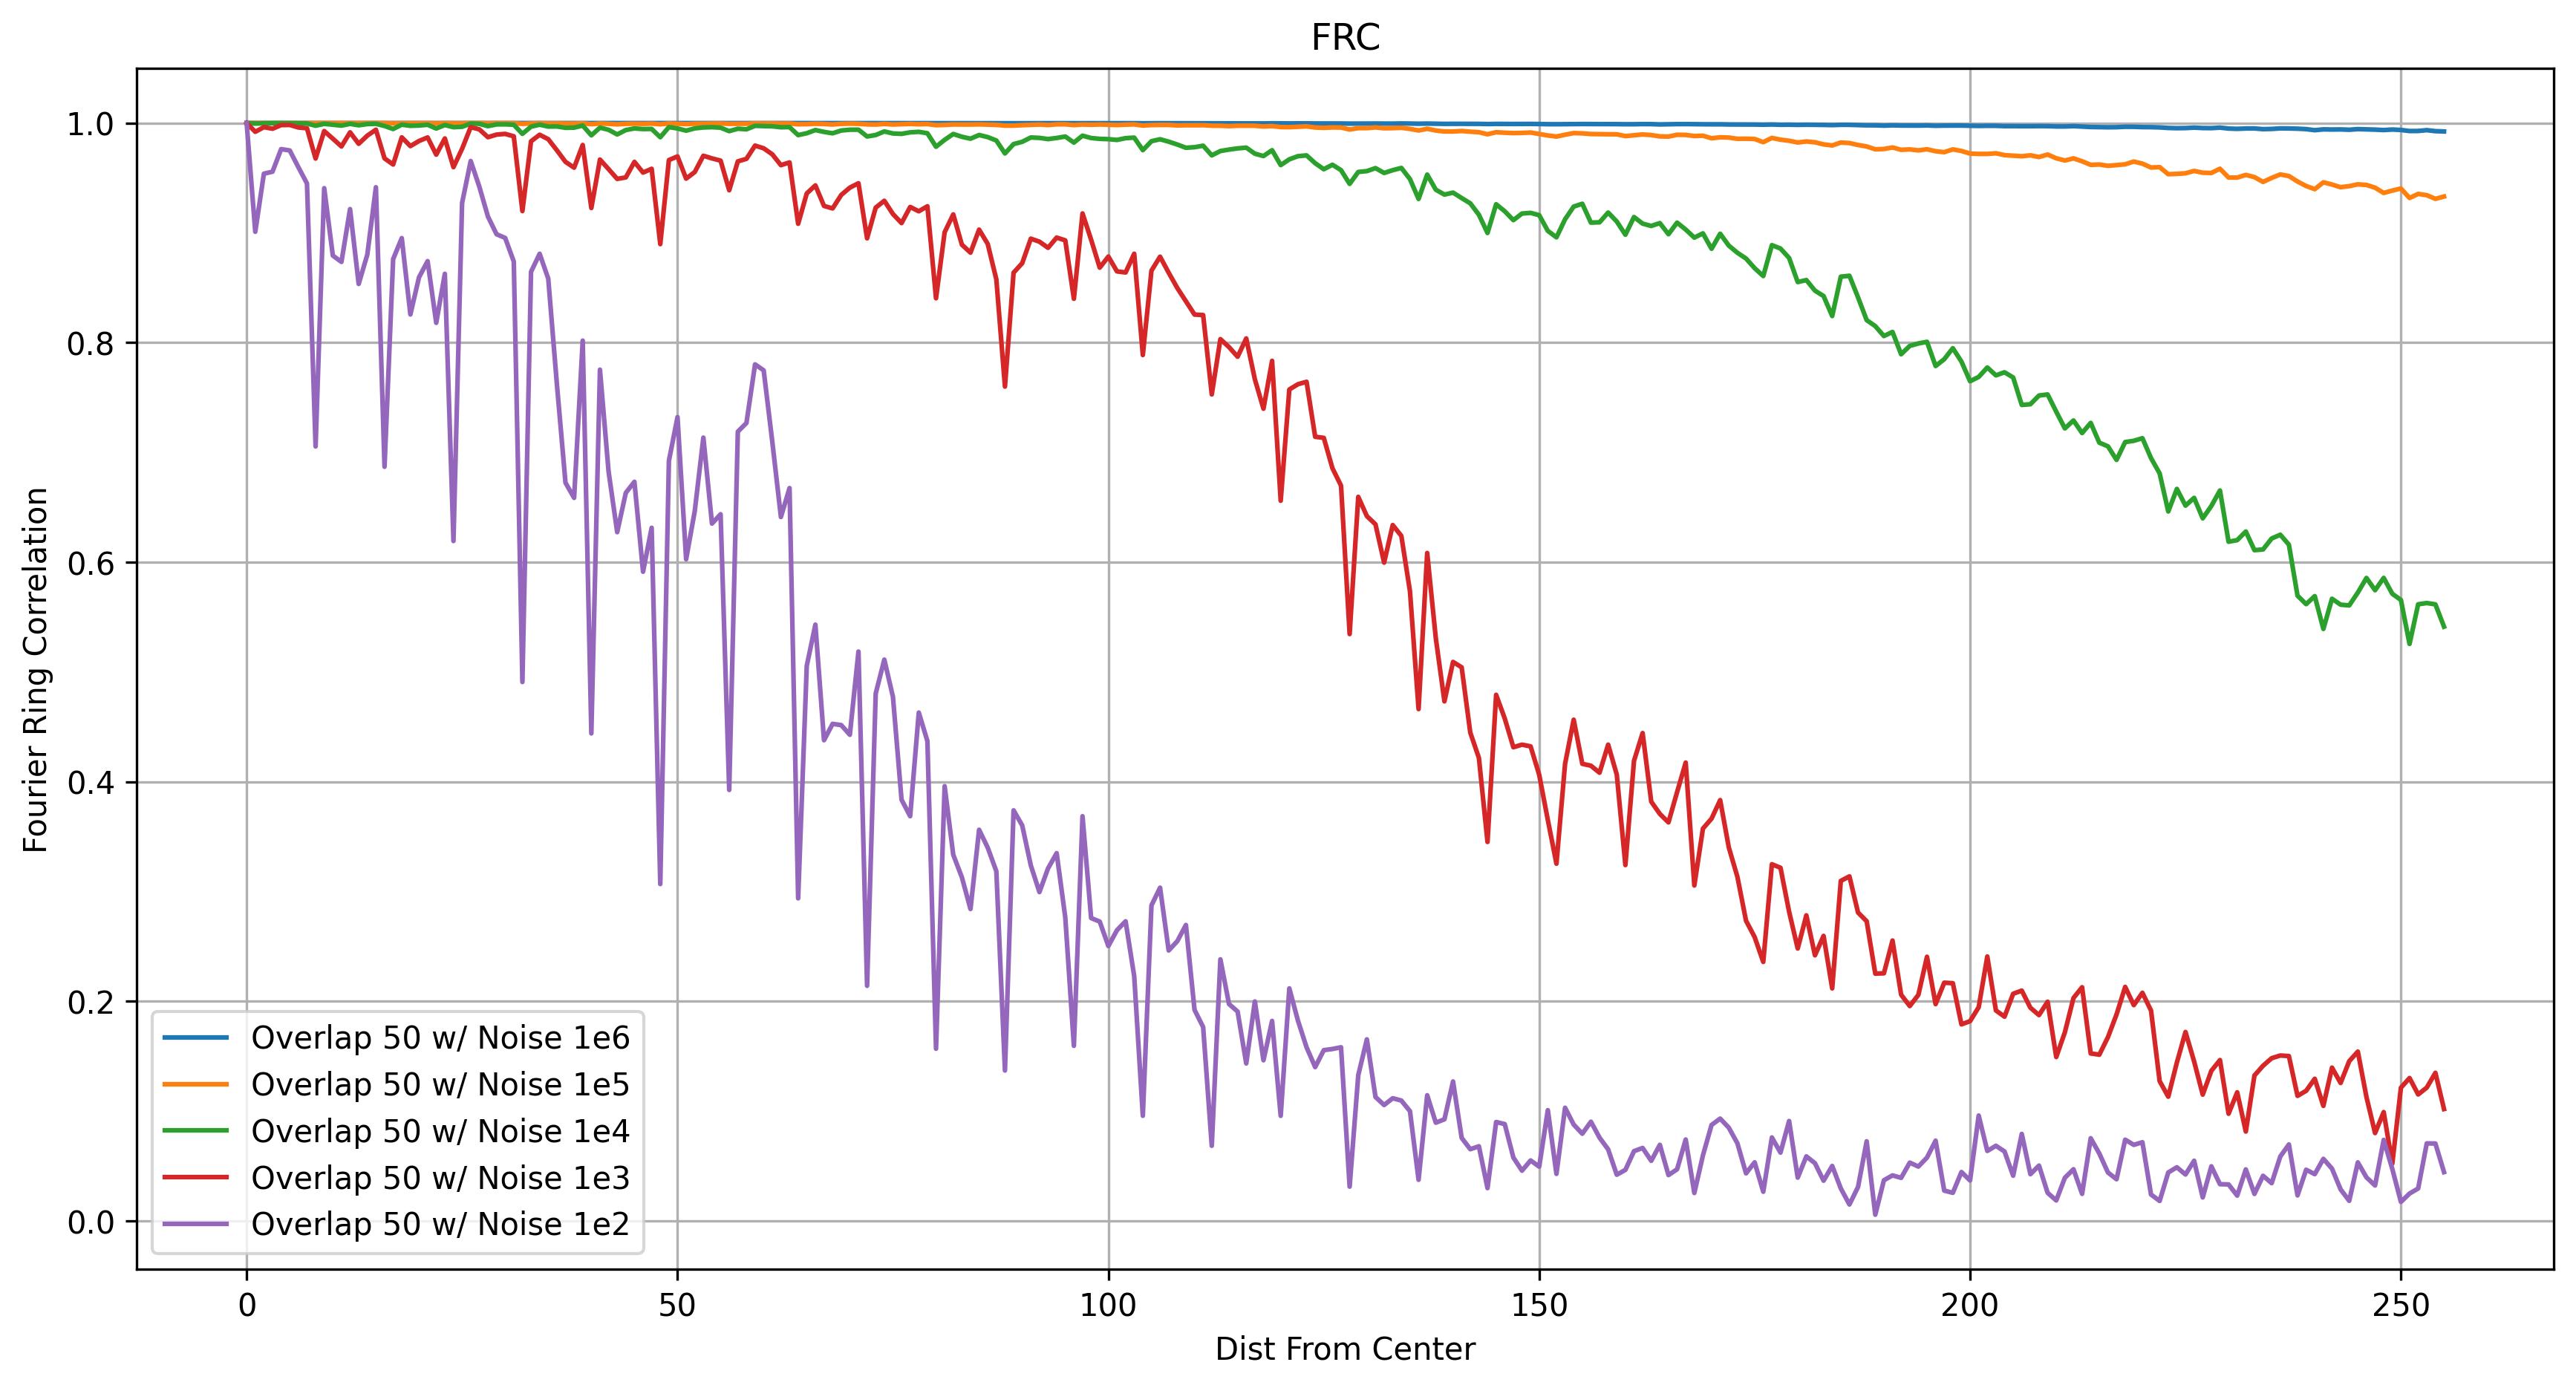

In [10]:
frc1 = np.load("data/cpwc_overlap50_mrgd_lambda1e-09_noise_typepoisson_noise1000000.0_frc.npy")
frc2 = np.load("data/cpwc_overlap50_mrgd_lambda1e-09_noise_typepoisson_noise100000.0_frc.npy")
frc3 = np.load("data/cpwc_overlap50_mrgd_lambda1e-09_noise_typepoisson_noise10000.0_frc.npy")
frc4 = np.load("data/cpwc_overlap50_mrgd_lambda1e-09_noise_typepoisson_noise1000.0_frc.npy")
frc5 = np.load("data/cpwc_overlap50_mrgd_lambda1e-09_noise_typepoisson_noise100.0_frc.npy")
plt.figure(dpi = 300,figsize=(14,7))
plt.plot(frc1)
plt.plot(frc2)
plt.plot(frc3)
plt.plot(frc4)
plt.plot(frc5)
plt.grid()
plt.legend(["Overlap 50 w/ Noise 1e6",
            "Overlap 50 w/ Noise 1e5",
            "Overlap 50 w/ Noise 1e4",
            "Overlap 50 w/ Noise 1e3",
            "Overlap 50 w/ Noise 1e2"])
plt.title("FRC")
plt.xlabel("Dist From Center")
plt.ylabel("Fourier Ring Correlation")
plt.show()


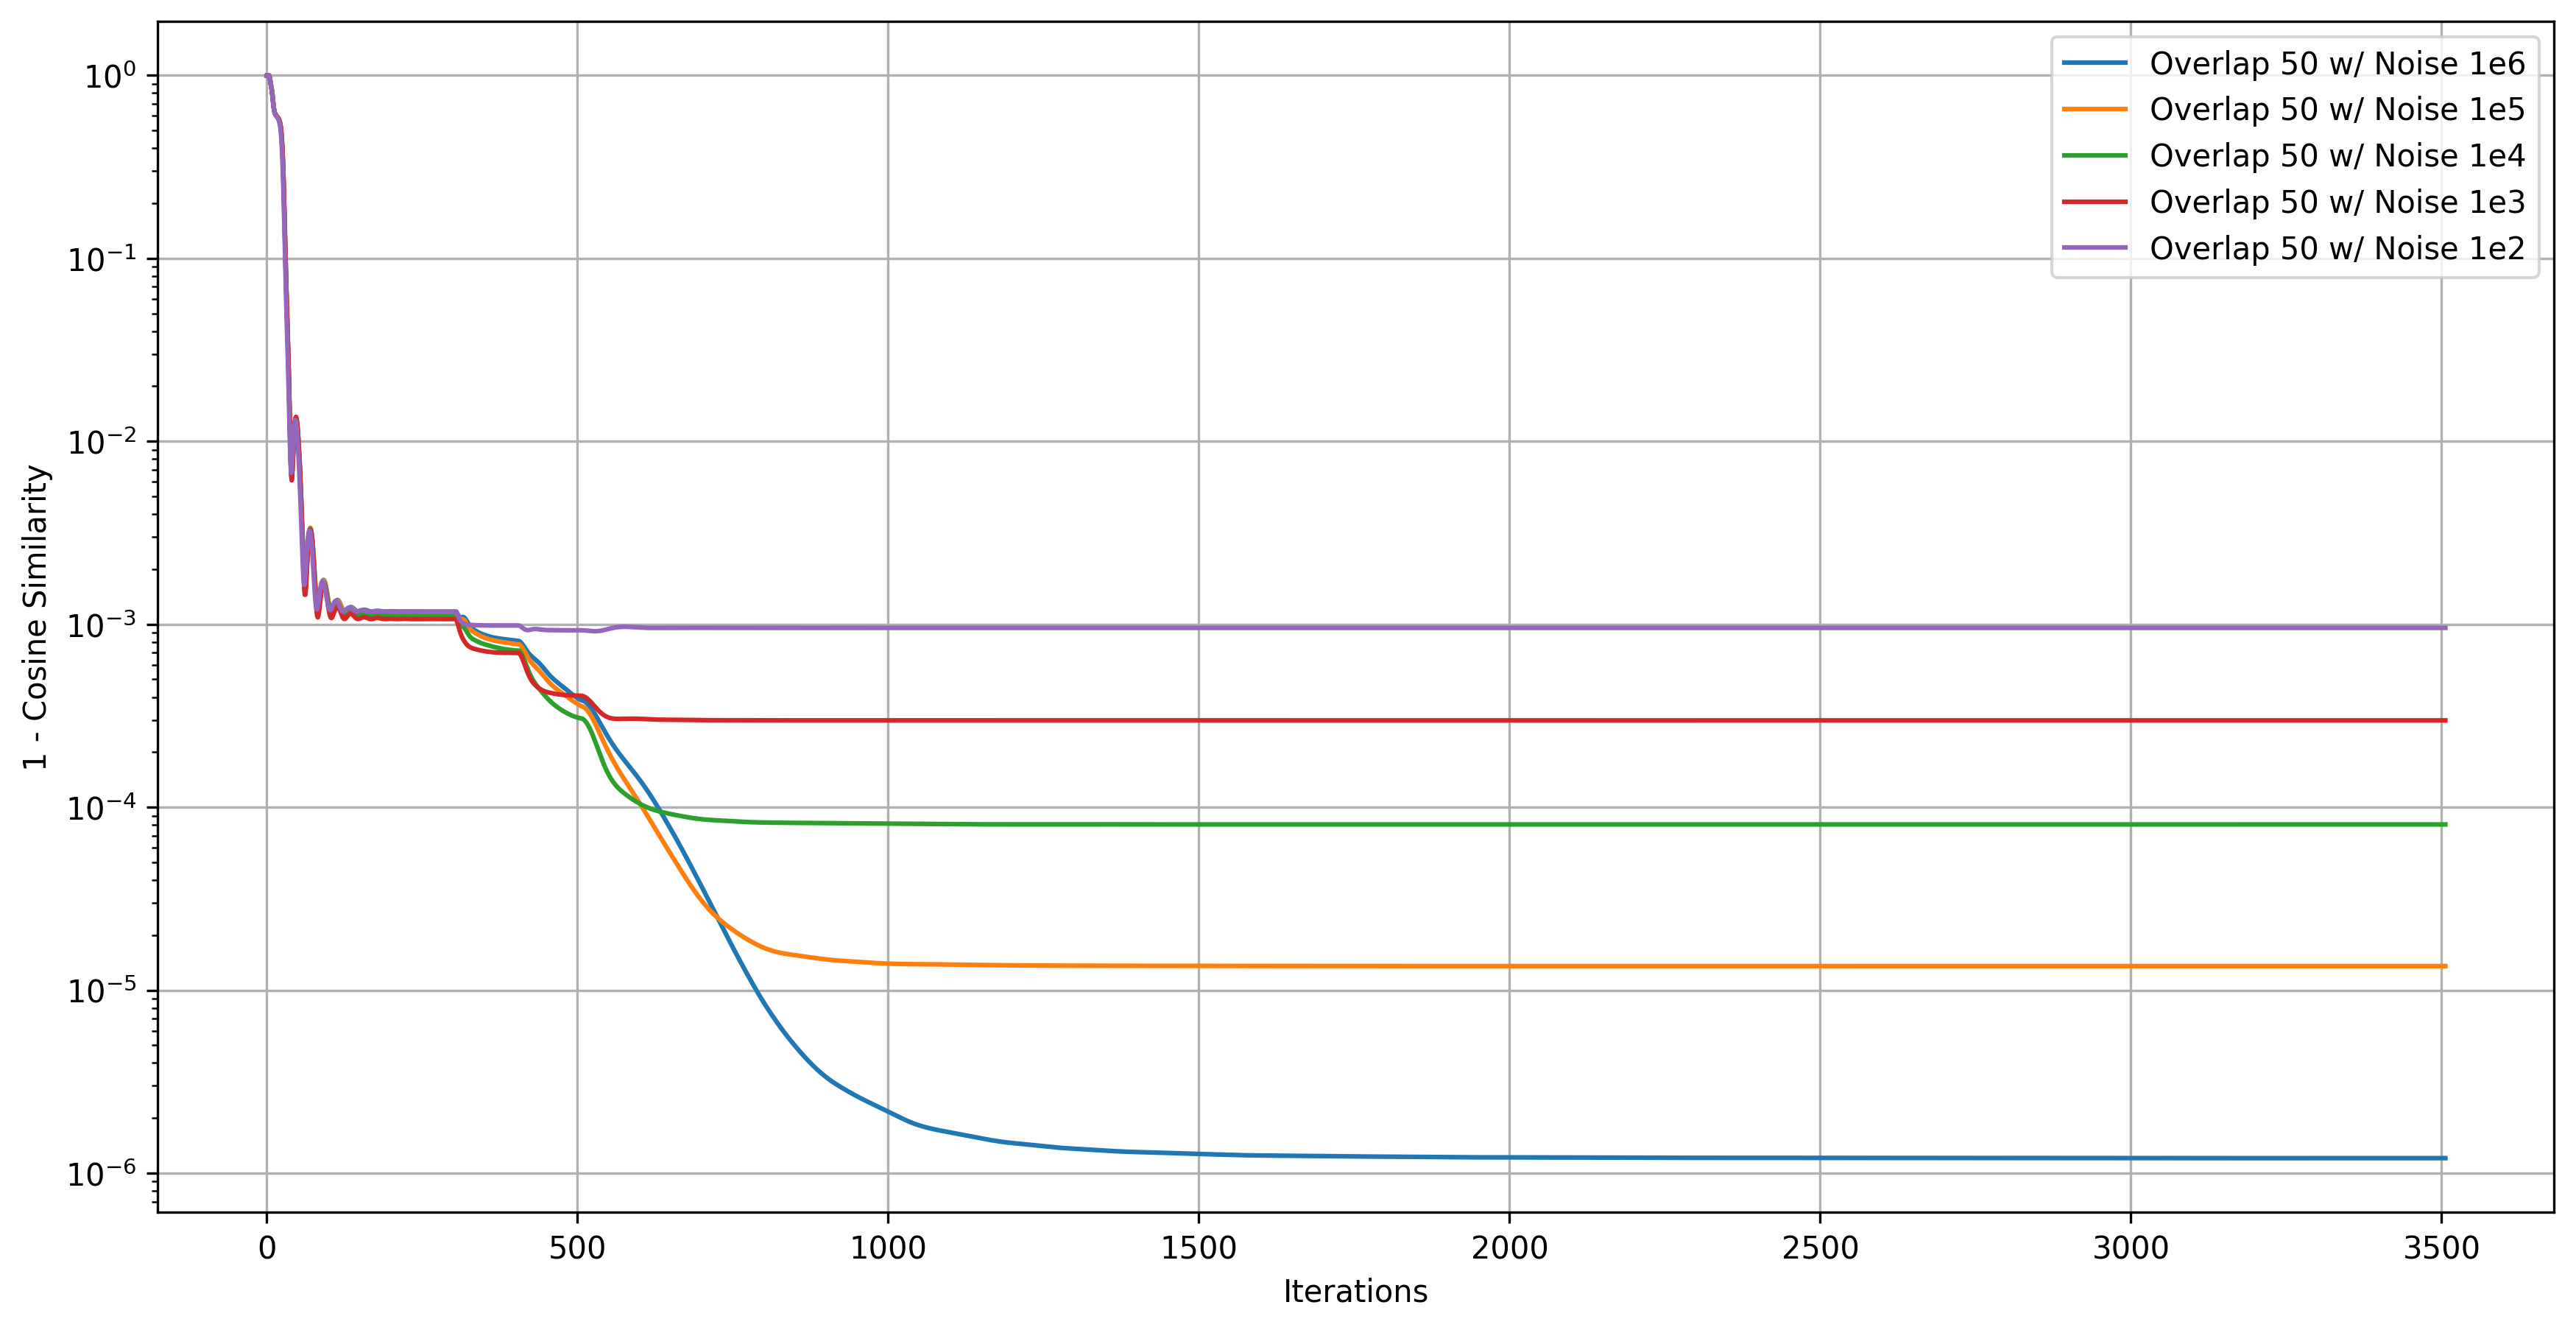

In [14]:
frc1 = np.load("data/cpwc_overlap50_mrgd_lambda1e-09_noise_typepoisson_noise1000000.0_csim.npy")
frc2 = np.load("data/cpwc_overlap50_mrgd_lambda1e-09_noise_typepoisson_noise100000.0_csim.npy")
frc3 = np.load("data/cpwc_overlap50_mrgd_lambda1e-09_noise_typepoisson_noise10000.0_csim.npy")
frc4 = np.load("data/cpwc_overlap50_mrgd_lambda1e-09_noise_typepoisson_noise1000.0_csim.npy")
frc5 = np.load("data/cpwc_overlap50_mrgd_lambda1e-09_noise_typepoisson_noise100.0_csim.npy")
plt.figure(dpi = 300,figsize=(14,7))
plt.semilogy(1 - frc1)
plt.semilogy(1 - frc2)
plt.semilogy(1 - frc3)
plt.semilogy(1 - frc4)
plt.semilogy(1 - frc5)
plt.grid()
plt.legend(["Overlap 50 w/ Noise 1e6",
            "Overlap 50 w/ Noise 1e5",
            "Overlap 50 w/ Noise 1e4",
            "Overlap 50 w/ Noise 1e3",
            "Overlap 50 w/ Noise 1e2"])
plt.xlabel("Iterations")
plt.ylabel("1 - Cosine Similarity")
plt.show()
